In [33]:
#!pip install -U scikit-learn
#!pip install seaborn

In [8]:
import os, time, copy, random, hashlib
import numpy as np
import torch, torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.cuda.amp import autocast, GradScaler
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [9]:
# Configuration
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Using device:", device)



🖥️ Using device: cuda


In [10]:
# Dataset & transforms

dataset_path = r"D:\Internship(sujesh)\PlantVillage"
img_size = 180

train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



In [11]:
import hashlib
from collections import defaultdict
from PIL import Image


import os, hashlib
from collections import defaultdict

def find_duplicate_images(folder_path):
    hash_map = defaultdict(list)
    for root, _, files in os.walk(folder_path):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif')):
                path = os.path.join(root, fname)
                try:
                    with open(path, 'rb') as f:
                        h = hashlib.md5(f.read()).hexdigest()
                    hash_map[h].append(path)
                except Exception as e:
                    print(f"❌ Error reading {path}: {e}")
    duplicates = {h: paths for h, paths in hash_map.items() if len(paths) > 1}
    return duplicates

dupes = find_duplicate_images(dataset_path)
total_duplicates = sum(len(paths) - 1 for paths in dupes.values())
print(f"🔍 Total duplicate images found: {total_duplicates}")

# def remove_duplicate_images(folder_path):
#     hash_map = defaultdict(list)
#     for root, _, files in os.walk(folder_path):
#         for fname in files:
#             if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif")):
#                 path = os.path.join(root, fname)
#                 try:
#                     with open(path, "rb") as f:
#                         h = hashlib.md5(f.read()).hexdigest()
#                     hash_map[h].append(path)
#                 except Exception as e:
#                     print(f"❌ Error reading {path}: {e}")
#     removed = []
#     for group in hash_map.values():
#         for dup in group[1:]:
#             try:
#                 os.remove(dup)
#                 removed.append(dup)
#             except Exception as e:
#                 print(f"⚠️ Could not delete {dup}: {e}")
#     print(f"✅ Removed {len(removed)} duplicate images.")
#     return removed

# remove_duplicate_images(dataset_path)




🔍 Total duplicate images found: 0


In [12]:
full_ds = datasets.ImageFolder(dataset_path, transform=train_tfms)
class_names = full_ds.classes
num_classes = len(class_names)

def build_densenet(num_classes, dropout=0.4):
    model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = True
    in_f = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_f, 512),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(512, num_classes)
    )
    return model.to(device)


In [110]:
# Model builder for DenseNet201
# def build_densenet(num_classes, dropout=0.4):
#     model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
#     for param in model.features.parameters():
#         param.requires_grad = True
#     in_f = model.classifier.in_features
#     model.classifier = nn.Sequential(
#         nn.Linear(in_f, 512), nn.ReLU(), nn.Dropout(dropout), nn.Linear(512, num_classes)
#     )
#     return model.to(device)

In [13]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.best_model = None
        self.stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True


In [14]:
from itertools import product


# 1️⃣ K-Fold CV + Hyperparameter Tuning
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
batch_sizes = [16]
learning_rates = [1e-4]
dropouts = [0.3]

for fold, (train_idx, val_idx) in enumerate(kf.split(full_ds)):
    print(f"\n🔁 Fold {fold+1}/{k_folds}")

    train_subset = torch.utils.data.Subset(full_ds, train_idx)
    val_subset = torch.utils.data.Subset(full_ds, val_idx)
    train_subset.dataset.transform = train_tfms
    val_subset.dataset.transform = val_tfms

    for bs, lr, do in product(batch_sizes, learning_rates, dropouts):
        print(f"\n🔧 Testing: Fold={fold+1} | BS={bs}, LR={lr}, DO={do}")

        batch_size = bs
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                  num_workers=4, pin_memory=True, persistent_workers=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                                num_workers=4, pin_memory=True, persistent_workers=True)

        train_size = len(train_subset)
        val_size = len(val_subset)

        model = torchvision.models.densenet121(pretrained=True)
        model.classifier = nn.Sequential(
            nn.Dropout(p=do),
            nn.Linear(model.classifier.in_features, num_classes)
        )
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
        early_stop = EarlyStopping(patience=5)

        history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'train_acc': []}
        max_epochs = 10
        scaler = GradScaler()

        for epoch in range(1, max_epochs + 1):
            t0 = time.time()

            # 🔹 Training
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            train_loss = running_loss / train_size
            train_acc = correct_train / total_train

            # 🔸 Validation
            model.eval()
            vloss, correct = 0.0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    vloss += loss.item() * images.size(0)
                    preds = outputs.argmax(1)
                    correct += (preds == labels).sum().item()

            val_loss = vloss / val_size
            val_acc = correct / val_size

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch:03}/{max_epochs} | train_loss {train_loss:.4f} | train_acc {train_acc*100:.2f}% | "
                  f"val_loss {val_loss:.4f} | val_acc {val_acc*100:.2f}% | time {time.time()-t0:.1f}s")

            scheduler.step(val_loss)
            for param_group in optimizer.param_groups:
                print(f"🔄 Learning Rate: {param_group['lr']}")

            early_stop(val_loss, model)
            if early_stop.stop:
                print("⏹ Early stopping triggered.")
                break

        model.load_state_dict(early_stop.best_model)
        model_path = f"densenet_fold{fold+1}_bs{bs}_lr{lr}_do{do}.pth"
        torch.save(model.state_dict(), model_path)
        print("✅ Best model saved to", model_path)



🔁 Fold 1/5

🔧 Testing: Fold=1 | BS=16, LR=0.0001, DO=0.3
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\STUDENT/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100.0%
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_14752\2647530428.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_14752\2647530428.py:58: FutureWarning: `torch.cuda.amp.autocast(args...

Epoch 001/10 | train_loss 0.3623 | train_acc 90.18% | val_loss 0.0523 | val_acc 98.50% | time 115.4s
🔄 Learning Rate: 0.0001
Epoch 002/10 | train_loss 0.0771 | train_acc 97.87% | val_loss 0.0583 | val_acc 98.18% | time 98.5s
🔄 Learning Rate: 0.0001
Epoch 003/10 | train_loss 0.0479 | train_acc 98.76% | val_loss 0.0306 | val_acc 99.18% | time 94.8s
🔄 Learning Rate: 0.0001
Epoch 004/10 | train_loss 0.0358 | train_acc 99.01% | val_loss 0.0194 | val_acc 99.39% | time 95.1s
🔄 Learning Rate: 0.0001
Epoch 005/10 | train_loss 0.0253 | train_acc 99.28% | val_loss 0.0332 | val_acc 98.91% | time 95.5s
🔄 Learning Rate: 0.0001
Epoch 006/10 | train_loss 0.0284 | train_acc 99.14% | val_loss 0.0277 | val_acc 99.25% | time 94.5s
🔄 Learning Rate: 0.0001
Epoch 007/10 | train_loss 0.0222 | train_acc 99.39% | val_loss 0.0230 | val_acc 99.27% | time 96.7s
🔄 Learning Rate: 1e-05
Epoch 008/10 | train_loss 0.0084 | train_acc 99.81% | val_loss 0.0136 | val_acc 99.59% | time 95.2s
🔄 Learning Rate: 1e-05
Epoch 009

In [18]:
# ✅ After K-Fold training 

from torch.utils.data import random_split

full_ds = datasets.ImageFolder(dataset_path, transform=train_tfms)

# Define split sizes (e.g., 10% test)
test_ratio = 0.1
test_size = int(test_ratio * len(full_ds))
remaining_size = len(full_ds) - test_size

# Split into remaining (train+val) and test
remaining_ds, test_ds = random_split(full_ds, [remaining_size, test_size], generator=torch.Generator().manual_seed(seed))

# Apply only validation transforms to test set
test_ds.dataset.transform = val_tfms

# Create DataLoader
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=4)

print(f"🧪 Test dataset created with {len(test_ds)} samples")


🧪 Test dataset created with 2062 samples


In [16]:
# ✅ Run on test set
model.eval()
correct_test, total_test = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_acc = correct_test / total_test
print(f"🧪 Final Test Accuracy: {test_acc * 100:.2f}%")


🧪 Final Test Accuracy: 99.95%


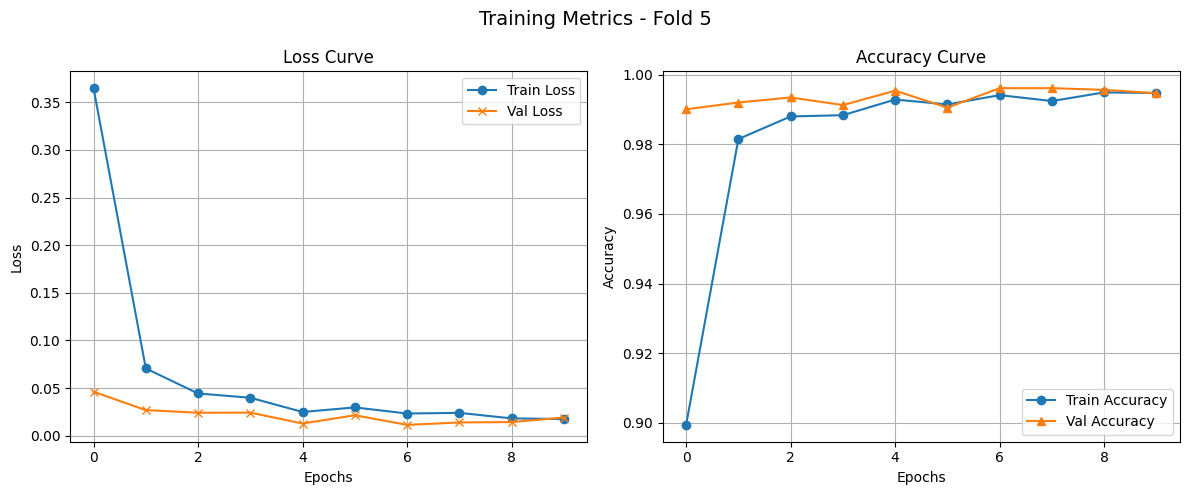

In [17]:
# Plot both Loss and Accuracy
plt.figure(figsize=(12, 5))

# 🔹 Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.legend()

# 🔸 Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Val Accuracy', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

plt.suptitle(f"Training Metrics - Fold {fold+1}", fontsize=14)
plt.tight_layout()
plt.show()

# Save CSV
pd.DataFrame(history).to_csv(f"history_fold{fold+1}_bs{bs}_lr{lr}_do{do}.csv", index=False)

📊 Classification Report
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       200
                     Pepper__bell___healthy       1.00      1.00      1.00       302
                      Potato___Early_blight       1.00      1.00      1.00       189
                       Potato___Late_blight       1.00      1.00      1.00       188
                           Potato___healthy       1.00      1.00      1.00        31
                      Tomato_Bacterial_spot       0.99      1.00      1.00       441
                        Tomato_Early_blight       0.99      0.99      0.99       191
                         Tomato_Late_blight       0.99      0.99      0.99       340
                           Tomato_Leaf_Mold       1.00      0.99      1.00       186
                  Tomato_Septoria_leaf_spot       1.00      1.00      1.00       390
Tomato_Spider_mites_Two_spotted_spider_m

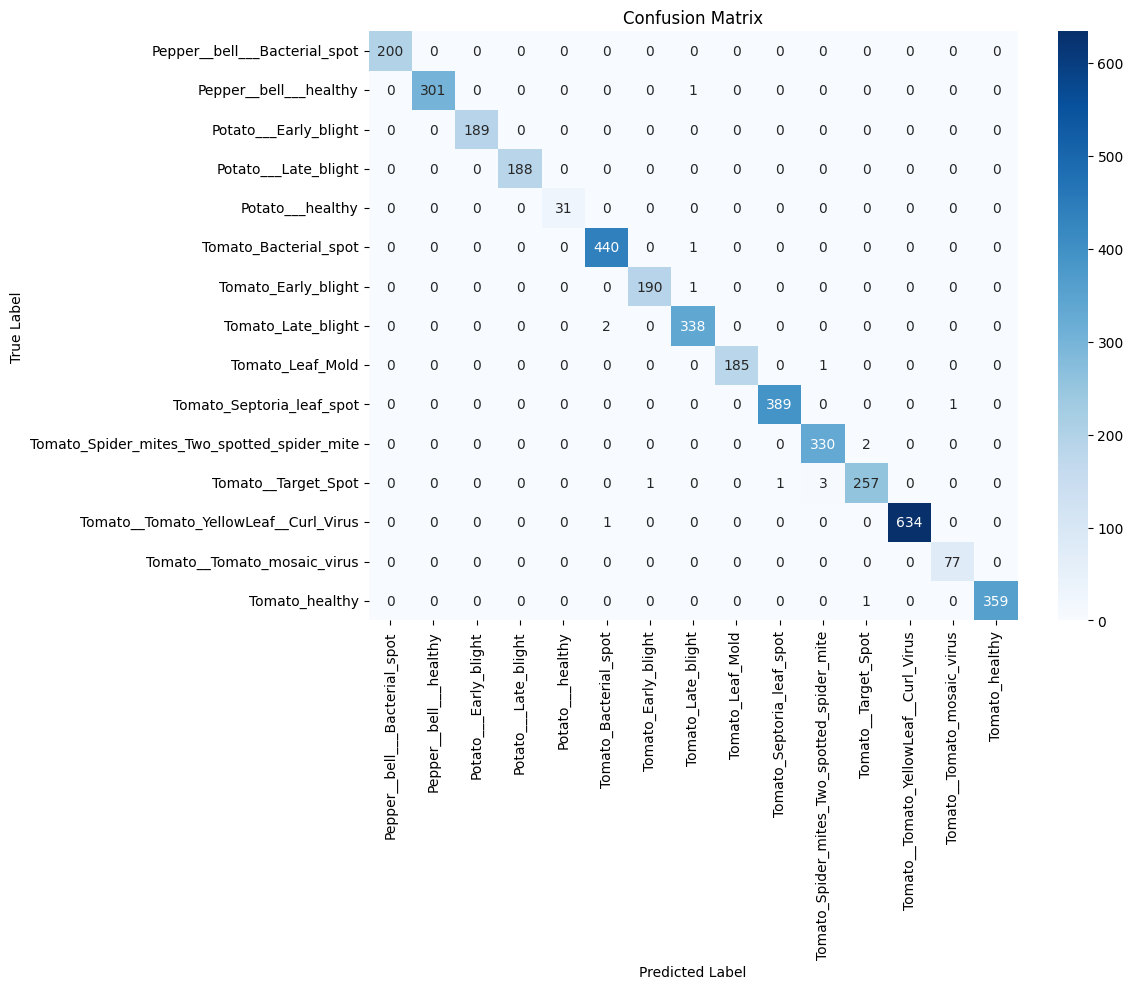

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 🟢 Collect predictions
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Classification Report
print("📊 Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names))

# 📌 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [19]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
torch.save(model.state_dict(), f"densenet_final_{timestamp}.pth")


In [20]:
best_val_acc = max(history['val_acc'])
best_val_loss = min(history['val_loss'])

results = []  # Definition of ResultArray

results.append({
    "batch_size": bs,
    "lr": lr,
    "dropout": do,
    "val_acc": best_val_acc,
    "val_loss": best_val_loss
})

results.append({
    "batch_size": bs,
    "lr": lr,
    "dropout": do,
    "val_acc": best_val_acc,  # capture from training loop
    "val_loss": best_val_loss
})

In [21]:
import pandas as pd
pd.DataFrame(results).to_csv("hyperparameter_results(DenseNet).csv", index=False)

In [1]:
#!pip install tensorboard


In [24]:
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter()

# Inside training loop:
writer.add_scalar("Loss/train", train_loss, epoch)
writer.add_scalar("Loss/val", val_loss, epoch)
writer.add_scalar("Accuracy/val", val_acc, epoch)

# After training
writer.close()

In [27]:
#!pip install opencv-python


In [14]:
import torchvision.models as models
import torch

import torchvision.models as models
import torch.nn as nn
import torch

NUM_CLASSES = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Recreate the model with matching classifier
model = models.densenet121(pretrained=False)
model.classifier = nn.Sequential(
    nn.ReLU(),
    nn.Linear(model.classifier.in_features, NUM_CLASSES)
)

# ✅ Load the trained weights
ckpt_path = "densenet_final_20250714-1608.pth"
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)

model.to(device).eval()

# ✅ Set up GradCAM
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)



C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
import torch
import cv2
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def save_grads(module, input, output):
            self.activations = output
            output.requires_grad_(True)  # Ensures hook works
            output.register_hook(self.save_gradient)

        self.target_layer.register_forward_hook(save_grads)

    def save_gradient(self, grad):
        self.gradients = grad

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        loss = output[:, class_idx]
        self.model.zero_grad()
        loss.backward()

        # Extract gradients and activations
        gradients = self.gradients[0].cpu().detach().numpy()
        activations = self.activations[0].cpu().detach().numpy()
        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_tensor.shape[2:])
        cam -= cam.min()
        cam /= cam.max()
        return cam


C:\Users\STUDENT\AppData\Local\Temp\ipykernel_17296\127970354.py:47: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


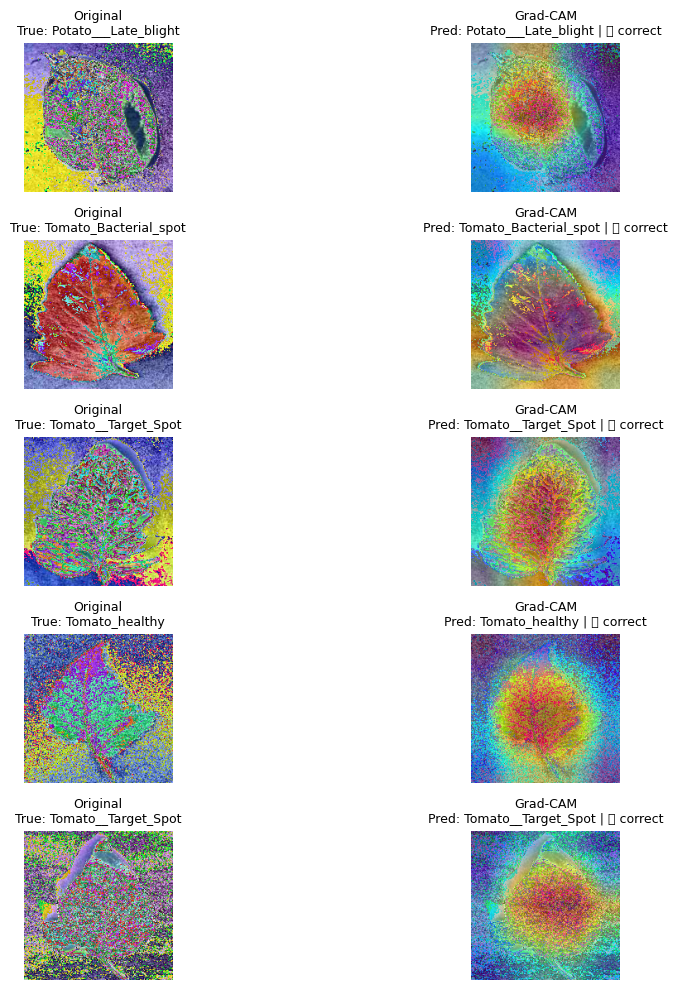

In [19]:
import matplotlib.pyplot as plt
import random

# ✅ Get class names from your dataset
class_names = full_ds.classes

# ✅ Pick random indices from your test dataset
N = 5
indices = random.sample(range(len(test_ds)), N)

# ✅ Plot original and Grad-CAM images side by side
plt.figure(figsize=(12, 2 * N))  # Taller layout for vertical stacking

for i, idx in enumerate(indices):
    img, true_label = test_ds[idx]
    img_batch = img.unsqueeze(0).to(device)

    # 🔮 Model prediction
    output = model(img_batch)
    pred_class = output.argmax(dim=1).item()
    pred_label = class_names[pred_class]
    true_label_name = class_names[true_label]
    status = "✅ correct" if pred_class == true_label else "❌ wrong"

    # 🔥 Generate Grad-CAM
    cam = gradcam.generate(img_batch)

    # Convert image & overlay heatmap
    img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # 🎨 Plot original image
    plt.subplot(N, 2, 2 * i + 1)
    plt.imshow(img_np)
    plt.title(f"Original\nTrue: {true_label_name}", fontsize=9)
    plt.axis("off")

    # 🎨 Plot Grad-CAM image
    plt.subplot(N, 2, 2 * i + 2)
    plt.imshow(overlay_rgb)
    plt.title(f"Grad-CAM\nPred: {pred_label} | {status}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()
